In [1]:
%pylab inline

import numpy as np

import matplotlib
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt

np.random.seed(6)

Populating the interactive namespace from numpy and matplotlib


### Degeneracy between faint, widely-separated dipole and bright, close dipole:

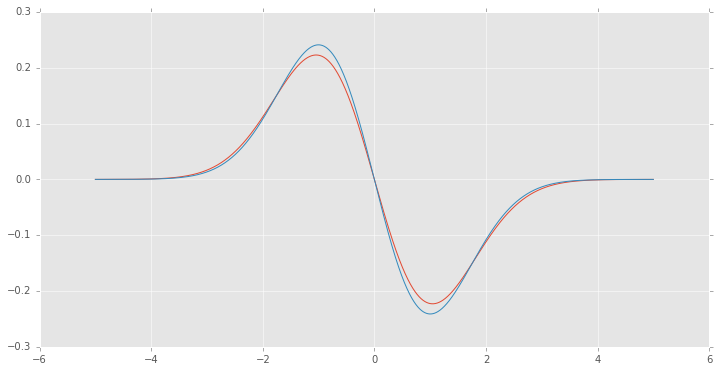

In [2]:
from scipy.stats import norm

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

x = np.arange(-5,5, 0.001)
plt.plot(x, 1. * (norm.pdf(x, -0.5, 1) - norm.pdf(x, 0.5, 1)))   ## faint, distant diple
plt.plot(x, 5. * (norm.pdf(x, -0.1, 1) - norm.pdf(x, 0.1, 1)))   ## bright, close dipole
plt.show()

### In the below, set amp1=1.3, sep1=0.8, amp2=5.0, amp2=0.2 ...

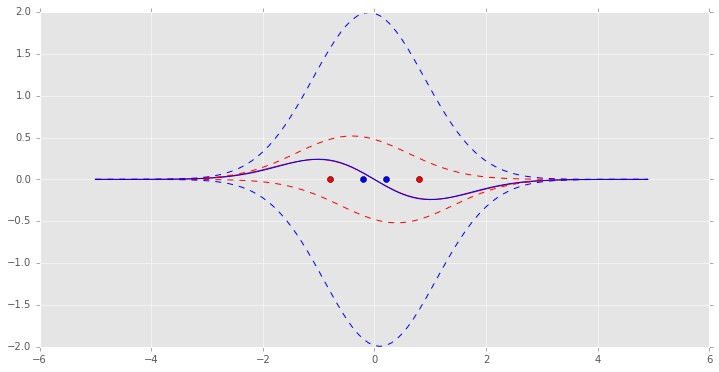

<function __main__.do_plot>

In [3]:
from ipywidgets import interact

def do_plot(amp1=1.3, sep1=0.8, amp2=5., sep2=0.2, show_components=True):
    x = np.arange(-5, 5, 0.1)
    plt.plot(x, amp1 * (norm.pdf(x, -sep1/2., 1) - norm.pdf(x, sep1/2., 1)), color='red')   ## faint, distant diple
    plt.plot(x, amp2 * (norm.pdf(x, -sep2/2., 1) - norm.pdf(x, sep2/2., 1)), color='blue')   ## bright, close dipole
    if show_components:
        plt.plot(x, amp1 *  norm.pdf(x, -sep1/2., 1), linestyle='dashed', color='red')
        plt.plot(x, amp1 * -norm.pdf(x,  sep1/2., 1), linestyle='dashed', color='red')
        plt.plot(x, amp2 *  norm.pdf(x, -sep2/2., 1), linestyle='dashed', color='blue')
        plt.plot(x, amp2 * -norm.pdf(x,  sep2/2., 1), linestyle='dashed', color='blue')
        
    plt.plot([-sep1, sep1], [0,0], 'ro')
    plt.plot([-sep2, sep2], [0,0], 'bo')
    plt.show()
    
##do_plot()

interact(do_plot, amp1=(0., 10.), sep1=(0., 2.), amp2=(0., 10.), sep2=(0., 2.), show_components=True)

### Try fitting it...

In [4]:
import lmfit

def gen_dipole2(x, amp1=1., sep1=1.):
    ypos = amp1 * norm.pdf(x,  sep1/2., 1)
    yneg = amp1 * norm.pdf(x, -sep1/2., 1)                  
    y = ypos - yneg
    return np.append(y, [ypos, yneg])

def gen_dipole(x, amp1=1., sep1=1.):
    #y = amp1 * (norm.pdf(x, -sep1/2., 1) - norm.pdf(x, sep1/2., 1))
    y = gen_dipole2(x, amp1, sep1)[:len(x)]
    return y

def fitDipole(ydata, xdata, amp1Start=3., sep1Start=2., fitFunc=gen_dipole, verbose=False):
    gmod = lmfit.Model(fitFunc, verbose=verbose)
    result = gmod.fit(ydata, x=xdata, amp1=amp1Start, sep1=sep1Start, verbose=verbose)

    if verbose: 
        print(result.fit_report(show_correl=False))
        ci = lmfit.conf_interval(result, result)
        lmfit.printfuncs.report_ci(ci)

    return result

 - Adding parameter "sep1"
 - Adding parameter "amp1"
[[Model]]
    Model(gen_dipole)
[[Fit Statistics]]
    # function evals   = 45
    # data points      = 40
    # variables        = 2
    chi-square         = 0.040
    reduced chi-square = 0.001
[[Variables]]
    sep1:   0.50559171 +/- 0.860081 (170.11%) (init= 1.5)
    amp1:   1.96640207 +/- 3.240087 (164.77%) (init= 1.5)

         99.70%    95.00%    67.40%    _BEST_    67.40%    95.00%    99.70%
 sep1:  -0.50559  -0.50559  -0.50559   0.50559  +0.54175  +0.89852  +1.21368
 amp1:  -1.31558  -1.19429  -0.97125   1.96640      +inf      +inf      +inf


/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/lmfit-0.9.2-py2.7.egg/lmfit/confidence.py:298: UserWarning: Warning, rel_change=9.99626580924e-06 < 0.01  at iteration 163 and prob(amp1=66.0711096335) = 0.236013350837 < max(sigmas).


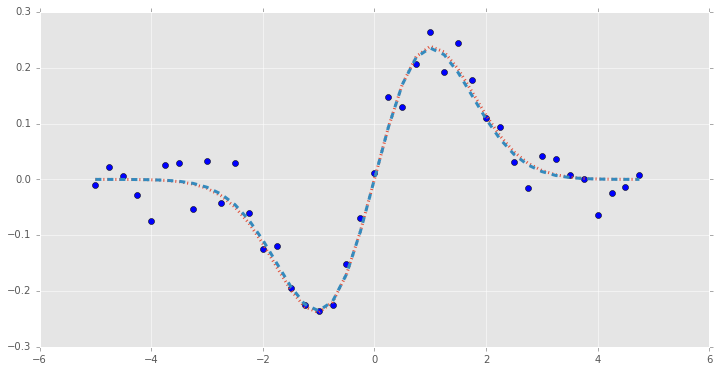

In [5]:
xdata = np.arange(-5, 5, 0.25)
ydataOrig = gen_dipole2(xdata, amp1=1.3, sep1=0.8)
ydataOrigNoisy = ydataOrig + np.random.normal(scale=0.03, size=ydataOrig.shape) ## save it for fitting below...
ydata = ydataOrigNoisy[:len(xdata)]    ## only fit the dipole (not pos/neg images)

result = fitDipole(ydata, xdata, amp1Start=1.5, sep1Start=1.5, fitFunc=gen_dipole, verbose=True)
plt.plot(xdata, ydata, 'bo')
plt.plot(xdata, ydataOrig[:len(xdata)], linewidth=3, linestyle='dotted')
plt.plot(xdata, result.best_fit, linewidth=3, linestyle='dashed')
plt.show()

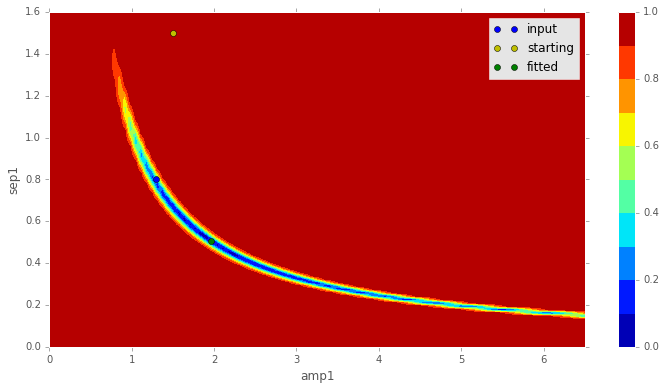

In [6]:
cx, cy, grid = lmfit.conf_interval2d(result, result, 'amp1', 'sep1', 100, 100, limits=((0.,6.5), (0., 1.6)))
plt.contourf(cx, cy, grid, np.linspace(0,1,11)) #, cmap=plt.cm.bone)
plt.xlabel('amp1'); plt.ylabel('sep1')
plt.colorbar()
lab_input, = plt.plot(1.3, 0.8, 'bo', label='input') ## input params
lab_starting, = plt.plot(1.5, 1.5, 'yo', label='starting') ## starting params
lab_fitted, = plt.plot(result.params['amp1'].value, result.params['sep1'].value, 'go', label='fitted')  ## fitted params
plt.legend([lab_input, lab_starting, lab_fitted], ['input', 'starting', 'fitted'])

The F-test is used to compare our null model, which is the best fit we have found, with an alternate model, where one of the parameters is fixed to a specific value. The value is changed until the difference between $\chi^2_0$ and $\chi^2_{f}$ can’t be explained by the loss of a degree of freedom within a certain confidence.

$F(P_{fix},N-P) = \left(\frac{\chi^2_f}{\chi^2_{0}}-1\right)\frac{N-P}{P_{fix}}$

$N$ is the number of data-points, $P$ the number of parameter of the null model. $P_{fix}$ is the number of fixed parameters (or to be more clear, the difference of number of parameters between our null model and the alternate model).

### Try my idea of using image and template separately to constrain fit...

 - Adding parameter "sep1"
 - Adding parameter "amp1"
[[Model]]
    Model(gen_dipole2)
[[Fit Statistics]]
    # function evals   = 15
    # data points      = 120
    # variables        = 2
    chi-square         = 0.106
    reduced chi-square = 0.001
[[Variables]]
    sep1:   0.78970505 +/- 0.027970 (3.54%) (init= 1.5)
    amp1:   1.30817951 +/- 0.019457 (1.49%) (init= 1.5)

         99.70%    95.00%    67.40%    _BEST_    67.40%    95.00%    99.70%
 sep1:  -0.08332  -0.05473  -0.02741   0.78971  +0.02771  +0.05593  +0.08617
 amp1:  -0.05890  -0.03853  -0.01919   1.30818  +0.01920  +0.03857  +0.05900


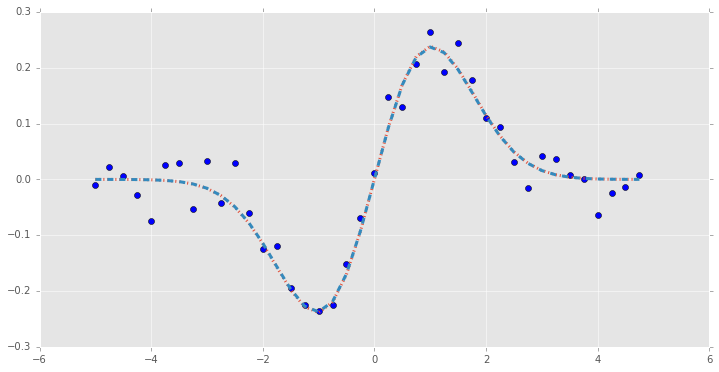

In [7]:
## Use same input data as above for direct comparison
ydata = ydataOrigNoisy
result = fitDipole(ydata, xdata, amp1Start=1.5, sep1Start=1.5, fitFunc=gen_dipole2, verbose=True)
plt.plot(xdata, ydata[:len(xdata)], 'bo')
plt.plot(xdata, ydataOrig[:len(xdata)], linewidth=3, linestyle='dotted')
plt.plot(xdata, result.best_fit[:len(xdata)], linewidth=3, linestyle='dashed')
plt.show()

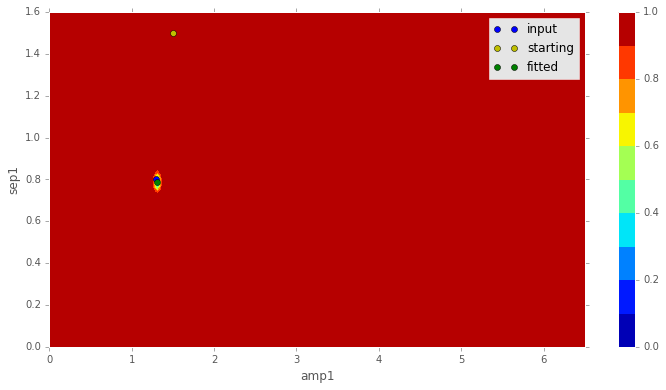

In [8]:
cx, cy, grid = lmfit.conf_interval2d(result, result, 'amp1', 'sep1', 100, 100, limits=((0.,6.5), (0., 1.6)))
plt.contourf(cx, cy, grid, np.linspace(0,1,11)) #, cmap=plt.cm.bone)
plt.xlabel('amp1'); plt.ylabel('sep1')
plt.colorbar()
lab_input, = plt.plot(1.3, 0.8, 'bo', label='input') ## input params
lab_starting, = plt.plot(1.5, 1.5, 'yo', label='starting') ## starting params
lab_fitted, = plt.plot(result.params['amp1'].value, result.params['sep1'].value, 'go', label='fitted')  ## fitted params
plt.legend([lab_input, lab_starting, lab_fitted], ['input', 'starting', 'fitted'])

### This above weights the 3 planes equally. Let's weight the dipole plane 10x more and see how it looks:

In [9]:
def fitDipole2(ydata, xdata, amp1Start=3., sep1Start=2., fitFunc=gen_dipole, verbose=False):
    gmod = lmfit.Model(fitFunc, verbose=verbose)
    weights = np.ones_like(ydata)
    weights[:len(xdata)] = 10.
    result = gmod.fit(ydata, x=xdata, weights=weights, amp1=amp1Start, sep1=sep1Start, verbose=verbose)

    if verbose: 
        print(result.fit_report(show_correl=False))
        ci = lmfit.conf_interval(result, result)
        lmfit.printfuncs.report_ci(ci)

    return result

 - Adding parameter "sep1"
 - Adding parameter "amp1"
[[Model]]
    Model(gen_dipole2)
[[Fit Statistics]]
    # function evals   = 18
    # data points      = 120
    # variables        = 2
    chi-square         = 4.127
    reduced chi-square = 0.035
[[Variables]]
    sep1:   0.76485077 +/- 0.074671 (9.76%) (init= 1.5)
    amp1:   1.32517610 +/- 0.116622 (8.80%) (init= 1.5)

         99.70%    95.00%    67.40%    _BEST_    67.40%    95.00%    99.70%
 sep1:  -0.17729  -0.12452  -0.06670   0.76485  +0.07783  +0.16959  +0.28282
 amp1:  -0.32487  -0.21819  -0.11081   1.32518  +0.11381  +0.23056  +0.35556


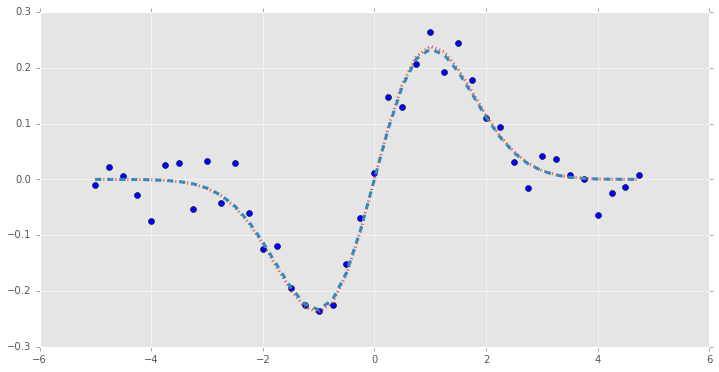

In [10]:
ydata = ydataOrigNoisy
result = fitDipole2(ydata, xdata, amp1Start=1.5, sep1Start=1.5, fitFunc=gen_dipole2, verbose=True)
plt.plot(xdata, ydata[:len(xdata)], 'bo')
plt.plot(xdata, ydataOrig[:len(xdata)], linewidth=3, linestyle='dotted')
plt.plot(xdata, result.best_fit[:len(xdata)], linewidth=3, linestyle='dashed')
plt.show()

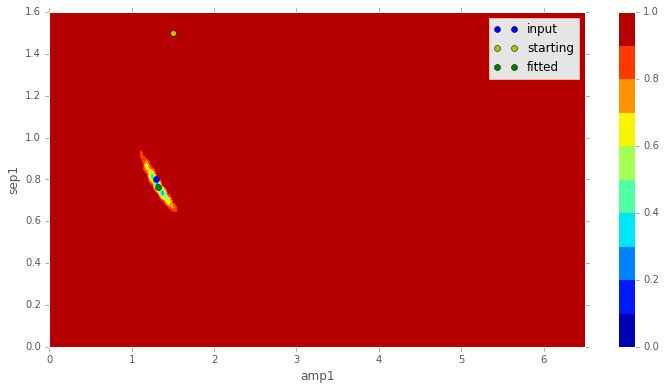

In [11]:
cx, cy, grid = lmfit.conf_interval2d(result, result, 'amp1', 'sep1', 100, 100, limits=((0.,6.5), (0., 1.6)))
plt.contourf(cx, cy, grid, np.linspace(0,1,11)) #, cmap=plt.cm.bone)
plt.xlabel('amp1'); plt.ylabel('sep1')
plt.colorbar()
lab_input, = plt.plot(1.3, 0.8, 'bo', label='input') ## input params
lab_starting, = plt.plot(1.5, 1.5, 'yo', label='starting') ## starting params
lab_fitted, = plt.plot(result.params['amp1'].value, result.params['sep1'].value, 'go', label='fitted')  ## fitted params
plt.legend([lab_input, lab_starting, lab_fitted], ['input', 'starting', 'fitted'])

## Instead of down-weighting the image planes, let's fit a background to it instead... (no background to the dipole, or maybe there should be eventually...)

In [12]:
def gen_dipole3(x, amp1=1., sep1=1., bg1=0.5):
    ypos = bg1 + amp1 * norm.pdf(x,  sep1/2., 1)
    yneg = bg1 + amp1 * norm.pdf(x, -sep1/2., 1)                  
    y = ypos - yneg
    return np.append(y, [ypos, yneg])

def fitDipole3(ydata, xdata, amp1Start=3., sep1Start=2., fitFunc=gen_dipole3, verbose=False):
    bg1start = np.median(ydata[len(xdata):])
    gmod = lmfit.Model(fitFunc, verbose=verbose)
    result = gmod.fit(ydata, x=xdata, amp1=amp1Start, sep1=sep1Start, bg1=bg1start, verbose=verbose)

    if verbose: 
        print(result.fit_report(show_correl=False))
        ci = lmfit.conf_interval(result, result)
        lmfit.printfuncs.report_ci(ci)

    return result

 - Adding parameter "bg1"
 - Adding parameter "amp1"
 - Adding parameter "sep1"
[[Model]]
    Model(gen_dipole3)
[[Fit Statistics]]
    # function evals   = 19
    # data points      = 120
    # variables        = 3
    chi-square         = 0.106
    reduced chi-square = 0.001
[[Variables]]
    bg1:    0.50045520 +/- 0.004137 (0.83%) (init= 0.5452806)
    amp1:   1.30665208 +/- 0.023970 (1.83%) (init= 1.5)
    sep1:   0.79031358 +/- 0.028668 (3.63%) (init= 1.5)

         99.70%    95.00%    67.40%    _BEST_    67.40%    95.00%    99.70%
 bg1 :  -0.01253  -0.00820  -0.00409   0.50046  +0.00409  +0.00820  +0.01255
 amp1:  -0.07253  -0.04744  -0.02363   1.30665  +0.02365  +0.04754  +0.07276
 sep1:  -0.08503  -0.05592  -0.02805   0.79031  +0.02843  +0.05749  +0.08874


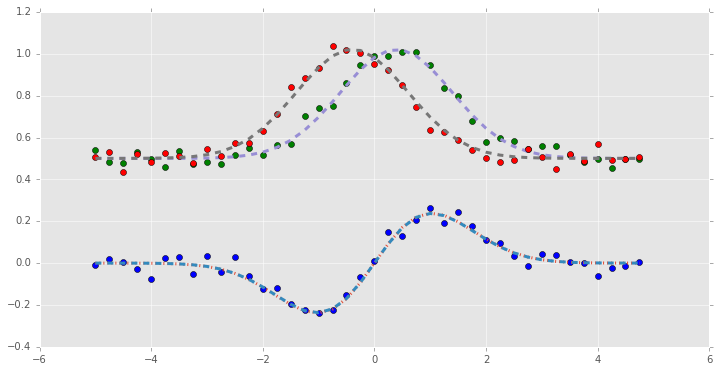

In [13]:
ydata = ydataOrigNoisy.copy()    ## copy it b/c we're gonna mess with it
ydata[len(xdata):2*len(xdata)] += 0.5
ydata[2*len(xdata):] += 0.5
result = fitDipole3(ydata, xdata, amp1Start=1.5, sep1Start=1.5, fitFunc=gen_dipole3, verbose=True)
plt.plot(xdata, ydata[:len(xdata)], 'bo')
plt.plot(xdata, ydataOrig[:len(xdata)], linewidth=3, linestyle='dotted')
plt.plot(xdata, result.best_fit[:len(xdata)], linewidth=3, linestyle='dashed')
plt.plot(xdata, ydata[len(xdata):2*len(xdata)], 'go')
plt.plot(xdata, result.best_fit[len(xdata):2*len(xdata)], linewidth=3, linestyle='dashed')
plt.plot(xdata, ydata[2*len(xdata):], 'ro')
plt.plot(xdata, result.best_fit[2*len(xdata):], linewidth=3, linestyle='dashed')
plt.show()

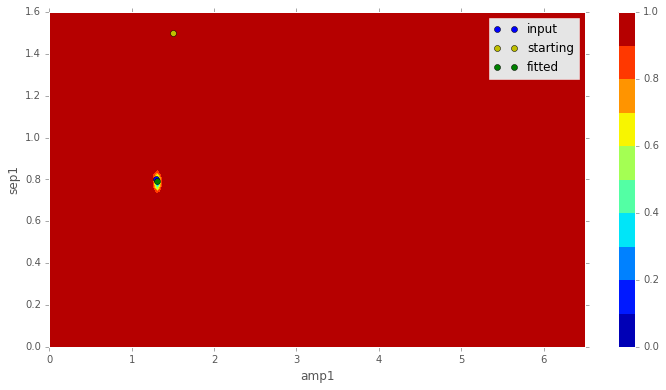

In [14]:
cx, cy, grid = lmfit.conf_interval2d(result, result, 'amp1', 'sep1', 100, 100, limits=((0.,6.5), (0., 1.6)))
plt.contourf(cx, cy, grid, np.linspace(0,1,11)) #, cmap=plt.cm.bone)
plt.xlabel('amp1'); plt.ylabel('sep1')
plt.colorbar()
lab_input, = plt.plot(1.3, 0.8, 'bo', label='input') ## input params
lab_starting, = plt.plot(1.5, 1.5, 'yo', label='starting') ## starting params
lab_fitted, = plt.plot(result.params['amp1'].value, result.params['sep1'].value, 'go', label='fitted')  ## fitted params
plt.legend([lab_input, lab_starting, lab_fitted], ['input', 'starting', 'fitted'])

## Now let's add a linear background gradient...

In [15]:
def gen_dipole4(x, amp1=1., sep1=1., bg1=0.5, bgslope1=0.02):
    ypos = bg1 + bgslope1*x + amp1 * norm.pdf(x,  sep1/2., 1)
    yneg = bg1 + bgslope1*x + amp1 * norm.pdf(x, -sep1/2., 1)                  
    y = ypos - yneg
    return np.append(y, [ypos, yneg])

def fitDipole4(ydata, xdata, amp1Start=3., sep1Start=2., bgslope1start=0., fitFunc=gen_dipole4, verbose=False):
    bg1start = np.median(ydata[len(xdata):])
    gmod = lmfit.Model(fitFunc, verbose=verbose)
    result = gmod.fit(ydata, x=xdata, amp1=amp1Start, sep1=sep1Start, bg1=bg1start, bgslope1=bgslope1start,
                      verbose=verbose)

    if verbose: 
        print(result.fit_report(show_correl=False))
        ci = lmfit.conf_interval(result, result)
        lmfit.printfuncs.report_ci(ci)

    return result

 - Adding parameter "bg1"
 - Adding parameter "bgslope1"
 - Adding parameter "amp1"
 - Adding parameter "sep1"
[[Model]]
    Model(gen_dipole4)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 120
    # variables        = 4
    chi-square         = 9.733
    reduced chi-square = 0.084
[[Variables]]
    bg1:        0.21579923 +/- 0.039966 (18.52%) (init= 0.4601957)
    bgslope1:   0.23065989 +/- 0.011227 (4.87%) (init= 0)
    amp1:       1.21641711 +/- 0.233342 (19.18%) (init= 1.5)
    sep1:       0.65733348 +/- 0.285215 (43.39%) (init= 1.5)

             99.70%    95.00%    67.40%    _BEST_    67.40%    95.00%    99.70%
 bg1     :  -0.12128  -0.07919  -0.03942   0.21580  +0.03936  +0.07895  +0.12072
 bgslope1:  -0.03404  -0.02224  -0.01108   0.23066  +0.01108  +0.02224  +0.03404
 amp1    :  -0.69390  -0.45661  -0.22860   1.21642  +0.23033  +0.46370  +0.71145
 sep1    :  -0.78563  -0.50839  -0.25912   0.65733  +0.29466  +0.66314  +1.20703


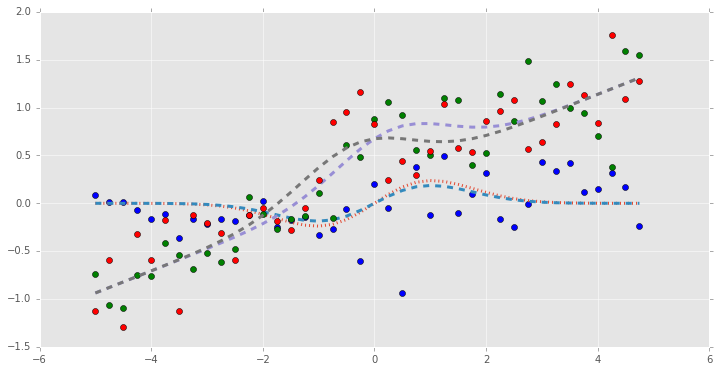

In [16]:
ydata = ydataOrig + np.random.normal(scale=0.3, size=ydataOrig.shape) ## make it super noisy
ydata[len(xdata):2*len(xdata)] += 0.2 + 0.234*xdata
ydata[2*len(xdata):] += 0.2 + 0.234*xdata
result = fitDipole4(ydata, xdata, amp1Start=1.5, sep1Start=1.5, fitFunc=gen_dipole4, verbose=True)
plt.plot(xdata, ydata[:len(xdata)], 'bo')
plt.plot(xdata, ydataOrig[:len(xdata)], linewidth=3, linestyle='dotted')
plt.plot(xdata, result.best_fit[:len(xdata)], linewidth=3, linestyle='dashed')
plt.plot(xdata, ydata[len(xdata):2*len(xdata)], 'go')
plt.plot(xdata, result.best_fit[len(xdata):2*len(xdata)], linewidth=3, linestyle='dashed')
plt.plot(xdata, ydata[2*len(xdata):], 'ro')
plt.plot(xdata, result.best_fit[2*len(xdata):], linewidth=3, linestyle='dashed')
plt.show()

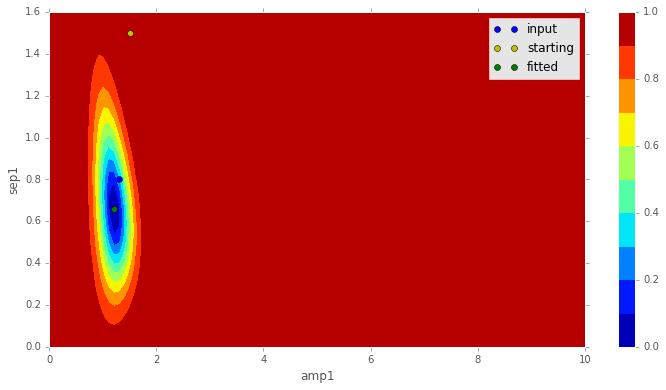

In [17]:
cx, cy, grid = lmfit.conf_interval2d(result, result, 'amp1', 'sep1', 100, 100, limits=((0.,10.), (0., 1.6)))
plt.contourf(cx, cy, grid, np.linspace(0,1,11)) #, cmap=plt.cm.bone)
plt.xlabel('amp1'); plt.ylabel('sep1')
plt.colorbar()
lab_input, = plt.plot(1.3, 0.8, 'bo', label='input') ## input params
lab_starting, = plt.plot(1.5, 1.5, 'yo', label='starting') ## starting params
lab_fitted, = plt.plot(result.params['amp1'].value, result.params['sep1'].value, 'go', label='fitted')  ## fitted params
plt.legend([lab_input, lab_starting, lab_fitted], ['input', 'starting', 'fitted'])

Compare this vs. if we did not have the pre-subtraction images.

 - Adding parameter "sep1"
 - Adding parameter "amp1"
[[Model]]
    Model(gen_dipole)
[[Fit Statistics]]
    # function evals   = 32
    # data points      = 40
    # variables        = 2
    chi-square         = 2.594
    reduced chi-square = 0.068
[[Variables]]
    sep1:   6.37100463 +/- 0.951098 (14.93%) (init= 1.5)
    amp1:   0.52957580 +/- 0.174439 (32.94%) (init= 1.5)



/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/lmfit-0.9.2-py2.7.egg/lmfit/confidence.py:298: UserWarning: Warning, rel_change=-0.00301352946991 < 0.01  at iteration 8 and prob(sep1=-1.23777995583) = 0.977544098777 < max(sigmas).
/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/lmfit-0.9.2-py2.7.egg/lmfit/confidence.py:298: UserWarning: Warning, rel_change=-6.57585173673e-05 < 0.01  at iteration 8 and prob(sep1=13.9797892192) = 0.995623369611 < max(sigmas).
/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/lmfit-0.9.2-py2.7.egg/lmfit/confidence.py:298: UserWarning: Warning, rel_change=-2.3850828045e-05 < 0.01  at iteration 5 and prob(amp1=-0.342623133188) = 0.995634727806 < max(sigmas).


         99.70%    95.00%    67.40%    _BEST_    67.40%    95.00%    99.70%
 sep1:      -inf  -3.21865  -1.08439   6.37100  +0.93761  +2.07810      +inf
 amp1:      -inf  -0.35311  -0.17357   0.52958  +0.17360  +0.35317  +0.55327


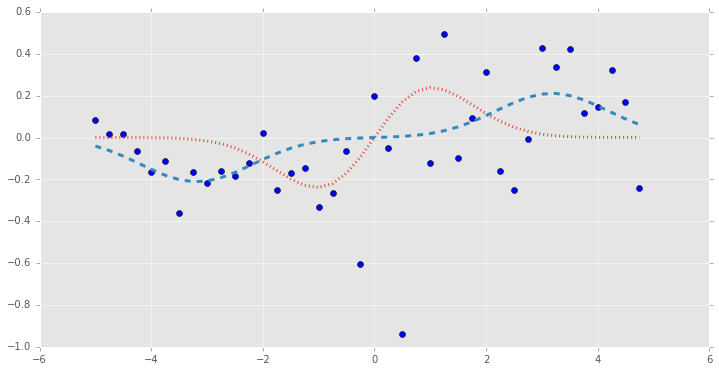

In [18]:
ydata = ydata[:len(xdata)]    ## only fit the dipole (not pos/neg images)
result = fitDipole(ydata, xdata, amp1Start=1.5, sep1Start=1.5, fitFunc=gen_dipole, verbose=True)
plt.plot(xdata, ydata, 'bo')
plt.plot(xdata, ydataOrig[:len(xdata)], linewidth=3, linestyle='dotted')
plt.plot(xdata, result.best_fit, linewidth=3, linestyle='dashed')
plt.show()

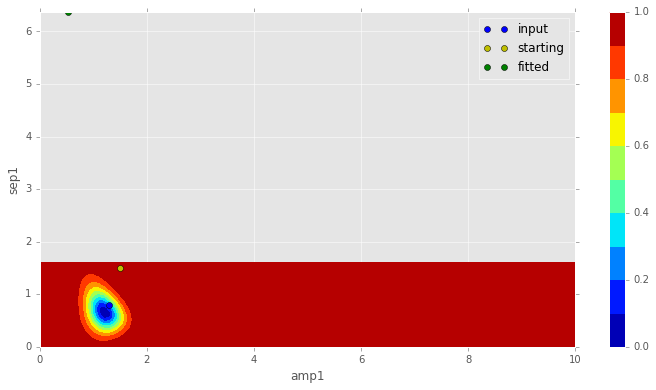

In [19]:
#cx, cy, grid = lmfit.conf_interval2d(result, result, 'amp1', 'sep1', 100, 100, limits=((0.,10.), (0., 1.6)))
plt.contourf(cx, cy, grid, np.linspace(0,1,11)) #, cmap=plt.cm.bone)
plt.xlabel('amp1'); plt.ylabel('sep1')
plt.colorbar()
lab_input, = plt.plot(1.3, 0.8, 'bo', label='input') ## input params
lab_starting, = plt.plot(1.5, 1.5, 'yo', label='starting') ## starting params
lab_fitted, = plt.plot(result.params['amp1'].value, result.params['sep1'].value, 'go', label='fitted')  ## fitted params
plt.legend([lab_input, lab_starting, lab_fitted], ['input', 'starting', 'fitted'])

TBD: possible different pos/neg background parameters and different pos/neg flux parameters.

Also possible background gradient in dipole image plane.